<a href="https://colab.research.google.com/github/resuarjunreddy/DISSERATATION-/blob/main/Arjun_Reddy_ch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Part A: Install / import libraries and load datasets
# Paste this into the first Colab cell.

# (Uncomment install lines only if needed in your environment)
# !pip install pandas numpy matplotlib seaborn scikit-learn wordcloud networkx openpyxl tensorflow==2.13.0

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from wordcloud import WordCloud
import networkx as nx
import re

# Keras for autoencoder
from tensorflow.keras import layers, models, losses, callbacks

# Paths used in Colab (adjust if you uploaded to a different path)
CSV_PATH = '/content/Dataset_T-ITS .csv'
XLSX_PATH = '/content/UAV_Security_Review_Table.xlsx'

# Load datasets (with defensive options)
print("Reading CSV:", CSV_PATH)
df_uav = pd.read_csv(CSV_PATH, low_memory=False)
print("Loaded UAV dataset rows:", df_uav.shape[0], "cols:", df_uav.shape[1])

print("Reading Excel:", XLSX_PATH)
df_bib = pd.read_excel(XLSX_PATH, engine='openpyxl')
print("Loaded bibliometric table rows:", df_bib.shape[0], "cols:", df_bib.shape[1])

# Quick peek
display(df_uav.head())
display(df_bib.head())

Reading CSV: /content/Dataset_T-ITS .csv
Loaded UAV dataset rows: 54783 cols: 38
Reading Excel: /content/UAV_Security_Review_Table.xlsx
Loaded bibliometric table rows: 16 cols: 16


,timestamp_c,frame.number,frame.len,frame.protocols,wlan.duration,wlan.ra,wlan.ta,wlan.da,wlan.sa,wlan.bssid,...,tcp.options,udp.srcport,udp.dstport,udp.length,data.data,data.len,wlan.fc.type,wlan.fc.subtype,time_since_last_packet,class
0,28105.9752,60,24,0,0,1,1,1,1,0,...,0,0,0,0,0,0,2,4,0,benign
1,28105.9755,61,24,0,0,1,1,1,1,0,...,0,0,0,0,0,0,2,4,0.000298,benign
2,28107.09931,75,104,0,0,4,1,4,1,0,...,0,0,0,0,0,0,0,8,1.123815,benign
3,28114.7857,122,86,2,44,1,0,1,0,0,...,1,0,0,0,0,0,2,8,7.686387,benign
4,28114.88188,124,26,0,60,1,0,1,0,0,...,0,0,0,0,0,0,2,12,0.096183,benign


,Authors (Year),Article Title,Research Focus / Topic Category,Vehicle Type,Security Area,Method Used,Dataset Used,Attack Types Studied,Strengths,Weaknesses,Key Findings,Limitations Identified by Authors,Proposed Solution / Framework,Performance Metrics Reported,Research Gap Identified,Relevance to Your Framework
0,Abreu et al. (2025),Cybersecurity in Connected and Autonomous Vehi...,Systematic review of CAV security,Autonomous Cars,"Cryptography, Authentication, Replay Attack Mi...",Cryptographic Protocol Analysis,No,"Replay, Forgery, DoS",Comprehensive review; strong protocol comparison,No experimental dataset; limited real-world va...,"Enhanced CAN security via TinyJAMBU, Gatekeepe...",Single point of failure in Gatekeeper; simulat...,Multi-layer cryptographic enhancements for CAV...,Not explicitly reported,Lack of unified framework for CAV security,Cryptography / Protocol Security
1,Mane and Sharma (2025),Securing Autonomous Vehicles: Cyber Attacks an...,Anomaly detection in AV communication,Autonomous Vehicles,"IDS, Sensor Attacks, Perception Attacks","DL, FL, Blockchain, Statistical Methods",Yes – multiple public datasets,"DoS, Spoofing, Perception Manipulation",Strong coverage of AV perception threats; mult...,Lacks experimental benchmarking of proposed so...,Overview of DL/FL IDS frameworks for AVs,No real-time system tests,Hybrid FL–DL anomaly detection architecture,Depends on dataset; not uniformly reported,"Need for real-time, robust AV IDS",ML / Privacy / Real-time IDS
2,Jayasri et al. (2025),Detecting cyber attacks in vehicle networks us...,Vehicular IDS optimization,Vehicular Networks,"IDS, Anomaly Detection","DL (LSTM), COA Optimization, DFT",Yes – UNSW-NB15,"Replay, Spoofing, DoS, Generic Attacks",Very high accuracy; optimized for real-time,High computational cost; relies on a single da...,ILSTM-COA optimized IDS framework,Computational load still significant,ILSTM with COA for adaptive detection,Accuracy 98.9%,"Need for real-time, multi-dataset vehicular IDS",ML-Based IDS
3,Li and Song (2025),GPS Spoofing on UAV Simulation using Ardupilot,GPS spoofing simulation,UAV,GPS Spoofing,Simulation + Python Injection Script,No (simulation only),GPS Spoofing,"Practical, low-cost GPS spoof simulation",No real drone testing; mitigation not evaluated,Ardupilot spoof simulation framework,Simulation limits realism,Framework for testing spoof attacks,Not applicable,Need real-world GPS spoof datasets,ML + Simulation (Spoofing)
4,Alsadie (2025),Cybersecurity and AI in UAVs: Challenges and C...,AI-driven UAV cybersecurity review,UAV,"AI Security, Adversarial ML, Blockchain, Ethics","ML, DL, FL, Adversarial ML, Blockchain",No,"Adversarial Patches, Data Injection, AI Attacks","Holistic integration of AI, blockchain, swarm ...",Purely conceptual; no experiments,Unified multi-layer UAV security framework,Lack of empirical validation,AI-enhanced IDS + Blockchain + PQC,Not reported,Need integrated real-time UAV defense,ML / Blockchain / Ethics


In [ ]:
# Part B: Robust cleaning helper functions and apply to both datasets.

def detect_placeholder_values(df, placeholder_list=None):
    """Return dict of columns where common placeholders appear and counts."""
    if placeholder_list is None:
        placeholder_list = [-1, -9999, 0, '', ' ', 'nan', 'NaN']
    found = {}
    for col in df.columns:
        counts = {}
        series = df[col].astype(object)
        for p in placeholder_list:
            try:
                # count equality safely (string vs numeric)
                counts[p] = int((series == p).sum())
            except Exception:
                counts[p] = 0
        # record only if any placeholder found
        if any(v>0 for v in counts.values()):
            found[col] = counts
    return found

# 1) Detect candidate placeholder values
placeholders_uav = detect_placeholder_values(df_uav, placeholder_list=[-1, -999, -9999, 0, '', np.nan])
print("Potential placeholders in UAV dataset (sample):")
for k,v in list(placeholders_uav.items())[:10]:
    print(k, v)

# 2) Replace obvious textual empty strings and 'nan' strings with actual np.nan
df_uav = df_uav.replace(['', ' ', 'nan', 'NaN', 'None'], np.nan)
df_bib = df_bib.replace(['', ' ', 'nan', 'NaN', 'None'], np.nan)

# 3) For numeric columns, if -1 (or other negative sentinels) used as missing, convert to NaN
# We'll heuristically convert -1 in columns where >1% of entries = -1 and column numeric.
def convert_sentinels_to_nan(df, sentinel=-1, threshold=0.01):
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            count = (df[col] == sentinel).sum()
            if count > 0 and (count / len(df) >= threshold):
                df.loc[df[col] == sentinel, col] = np.nan
                # print for logging
                print(f"Converted {count} values == {sentinel} to NaN in numeric column '{col}'")
convert_sentinels_to_nan(df_uav, sentinel=-1, threshold=0.0001)  # aggressive for dataset specifics

# 4) Columns with obviously wrong zeros (like ip.ttl==0 maybe invalid) - flag them
zero_flag_cols = [col for col in df_uav.columns if pd.api.types.is_numeric_dtype(df_uav[col]) and (df_uav[col]==0).sum() / len(df_uav) > 0.3]
print("Columns with many zeros (inspect):", zero_flag_cols)

# 5) Impute numeric and categorical columns with sensible strategies
def impute_df(df, strategy_numeric='median', strategy_categorical='most_frequent'):
    num_cols = df.select_dtypes(include=[np.number]).columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns

    # Numeric imputer
    num_imputer = SimpleImputer(strategy=strategy_numeric)
    if len(num_cols) > 0:
        df[num_cols] = num_imputer.fit_transform(df[num_cols])

    # Categorical imputer
    cat_imputer = SimpleImputer(strategy=strategy_categorical, fill_value='unknown')
    if len(cat_cols) > 0:
        df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

    return df

# Make copies before imputation for safety
df_uav_clean = df_uav.copy()
df_bib_clean = df_bib.copy()

df_uav_clean = impute_df(df_uav_clean, strategy_numeric='median', strategy_categorical='most_frequent')
df_bib_clean = impute_df(df_bib_clean, strategy_numeric='median', strategy_categorical='most_frequent')

print("After imputation, UAV dataset null counts (sample):")
display(df_uav_clean.isna().sum().sort_values().tail(10))

Potential placeholders in UAV dataset (sample):
Columns with many zeros (inspect): []
After imputation, UAV dataset null counts (sample):


,0
tcp.options,0
udp.srcport,0
udp.dstport,0
udp.length,0
data.data,0
data.len,0
wlan.fc.type,0
wlan.fc.subtype,0
time_since_last_packet,0
class,0


In [ ]:
# Part C: Prepare features for anomaly detection / classification.

# 1) Identify label column: many versions use 'class' or 'label' — check and create 'label' column.
label_col = None
for candidate in ['class','Class','label','attack','Attack','type','Type']:
    if candidate in df_uav_clean.columns:
        label_col = candidate
        break
print("Using label column:", label_col)

# If label not found assume last column is class
if label_col is None:
    label_col = df_uav_clean.columns[-1]
    print("Falling back to last column as label:", label_col)

# Standardize label names (lowercase)
df_uav_clean['label'] = df_uav_clean[label_col].astype(str).str.lower()

# Map common label variants to canonical classes (aggressive mapping)
label_map = {
    'benign':'benign',
    'normal':'benign',
    'doS':'dos','dos':'dos','doS attack':'dos',
    'replay':'replay','evil twin':'evil_twin','evil_twin':'evil_twin',
    'fdi':'fdi','false data injection':'fdi','fdI':'fdi'
}
# fallback: if not in map keep original token with underscores
df_uav_clean['label'] = df_uav_clean['label'].apply(lambda x: label_map.get(x.strip(), x.strip().replace(' ', '_')))

# 2) Choose candidate numeric features (drop textual packet columns like ip.src/ip.dst if too unique)
# We'll keep numeric columns only for ML baseline. Also convert bools / categories to numeric via label encoding.
numeric_cols = df_uav_clean.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric cols (sample):", numeric_cols[:20])

# 3) If too many numeric cols or high-cardinality columns, drop some high-card cols like ip.src/ip.dst if present
drop_candidates = []
for c in ['ip.src','ip.dst','wlan.sa','wlan.bssid','tcp.seq_raw','tcp.ack_raw','data.data']:
    if c in df_uav_clean.columns:
        drop_candidates.append(c)
print("Dropping candidate high-card columns if present:", drop_candidates)
X = df_uav_clean.drop(columns=drop_candidates + [label_col] if label_col in df_uav_clean.columns else drop_candidates)

# 4) Encode remaining non-numeric columns
for col in X.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# 5) Final feature matrix
X_numeric = X.select_dtypes(include=[np.number]).copy()
y = df_uav_clean['label'].copy()

print("Final feature matrix shape:", X_numeric.shape)
print("Class distribution:")
print(y.value_counts())

Using label column: class
Numeric cols (sample): []
Dropping candidate high-card columns if present: ['ip.src', 'ip.dst', 'wlan.sa', 'wlan.bssid', 'tcp.seq_raw', 'tcp.ack_raw', 'data.data']
Final feature matrix shape: (54783, 31)
Class distribution:
label
replay        33685
dos_attack    11671
benign         9425
class             2
Name: count, dtype: int64


IsolationForest as binary detector — classification report:
              precision    recall  f1-score   support

     anomaly       0.94      0.94      0.94     45358
      benign       0.72      0.69      0.70      9425

    accuracy                           0.90     54783
   macro avg       0.83      0.82      0.82     54783
weighted avg       0.90      0.90      0.90     54783

RandomForest multiclass results:
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      2356
       class       1.00      1.00      1.00         1
  dos_attack       1.00      1.00      1.00      2918
      replay       1.00      1.00      1.00      8421

    accuracy                           1.00     13696
   macro avg       1.00      1.00      1.00     13696
weighted avg       1.00      1.00      1.00     13696

Top features (RF):


,0
label,0.293880
timestamp_c,0.175491
wlan.duration,0.071737
wlan.fc.type,0.068328
wlan.seq,0.046549
time_since_last_packet,0.040245
wlan.fc.subtype,0.029119
llc.type,0.026486
wlan.ta,0.024239
wlan.frag,0.020889


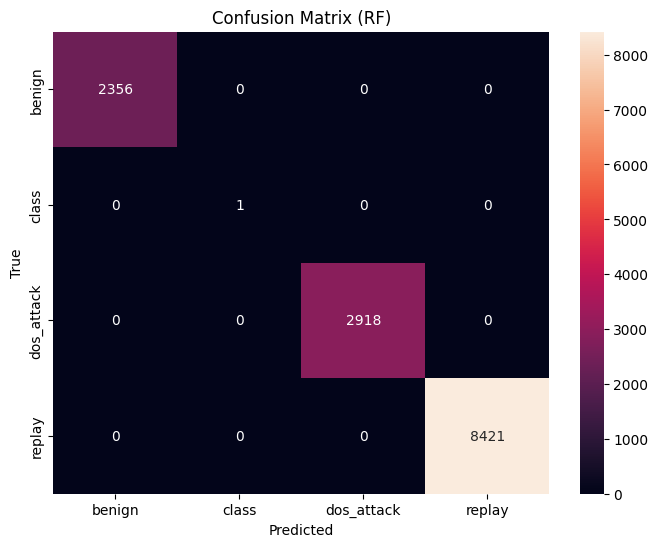

In [ ]:
# Part D: Two baseline approaches:
#  D1) Unsupervised anomaly detection: IsolationForest trained on 'benign' only (common setup).
#  D2) Supervised multiclass classifier (Random Forest) for multi-class detection.

# Split: Train on a mix but for IsolationForest we'll train purely on benign subset.
seed = 42

# Prepare data arrays
X_arr = X_numeric.values
y_arr = y.values

# 1) IsolationForest (train on benign only)
benign_mask = (y == 'benign')
X_benign = X_numeric[benign_mask]

iso = IsolationForest(n_estimators=200, contamination='auto', random_state=seed, n_jobs=-1)
iso.fit(X_benign)  # train only on benign

# Predict anomaly score on whole dataset
iso_preds = iso.predict(X_numeric)  # -1 => anomaly, 1 => normal
# map to labels
iso_pred_labels = np.where(iso_preds == 1, 'benign', 'anomaly')

# Evaluate isolation forest as binary detector
y_true_binary = np.where(y == 'benign', 'benign', 'anomaly')
print("IsolationForest as binary detector — classification report:")
print(classification_report(y_true_binary, iso_pred_labels, zero_division=0))

# 2) Supervised classifier — RandomForest (multiclass)
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.25, stratify=y, random_state=seed)

rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=seed, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("RandomForest multiclass results:")
print(classification_report(y_test, y_pred, zero_division=0))

# Feature importance top 15
imp = pd.Series(rf.feature_importances_, index=X_numeric.columns).sort_values(ascending=False)[:15]
print("Top features (RF):")
display(imp)

# Confusion matrix plot
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (RF)")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0656 - val_loss: 1.0085
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8779 - val_loss: 0.7469
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6662 - val_loss: 0.5321
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4759 - val_loss: 0.4054
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3353 - val_loss: 0.3335
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2503 - val_loss: 0.2924
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2101 - val_loss: 0.2676
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1860 - val_loss: 0.2486
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1708 - val_loss: 0.2356
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1620 - val_loss: 0.2261
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1559 - val_loss: 0.2192
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

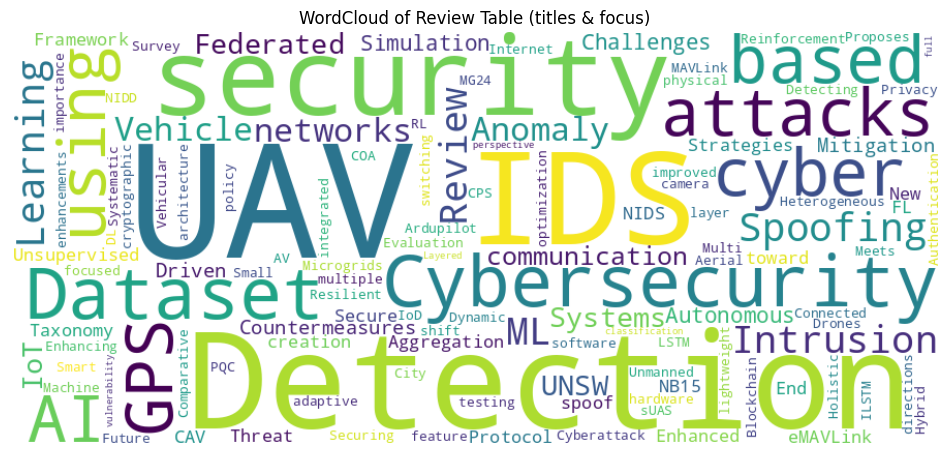

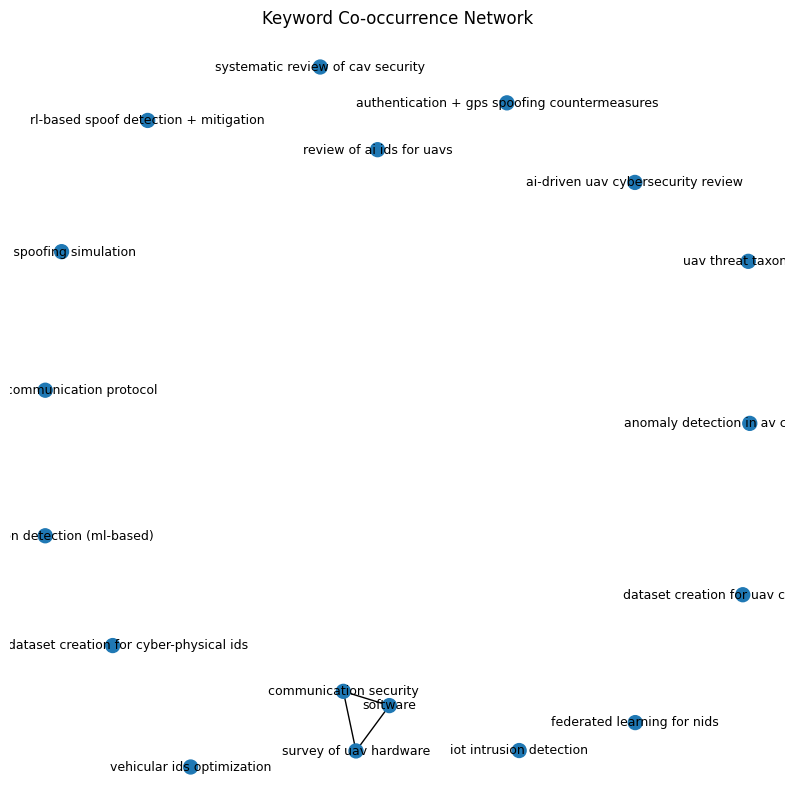

In [ ]:
# Part E1: Simple dense autoencoder trained on benign telemetry to detect anomalies (telemetry reconstruction error)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Train autoencoder on benign samples only
X_benign_scaled = scaler.transform(X_benign)

# Build autoencoder
input_dim = X_benign_scaled.shape[1]
encoding_dim = max(8, input_dim // 4)

inputs = layers.Input(shape=(input_dim,))
h = layers.Dense(encoding_dim*2, activation='relu')(inputs)
h = layers.Dense(encoding_dim, activation='relu')(h)
h = layers.Dense(encoding_dim, activation='relu')(h)
decoded = layers.Dense(input_dim, activation='linear')(h)

autoencoder = models.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = autoencoder.fit(X_benign_scaled, X_benign_scaled,
                          epochs=100,
                          batch_size=256,
                          validation_split=0.1,
                          callbacks=[es],
                          verbose=1)

# Compute reconstruction error on entire dataset
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.square(reconstructions - X_scaled), axis=1)

# Choose threshold: mean + 3*std of benign MSE
benign_mse = mse[benign_mask.values]
threshold = benign_mse.mean() + 3 * benign_mse.std()
print("Autoencoder threshold:", threshold)

ae_pred = np.where(mse <= threshold, 'benign', 'anomaly')
y_true_binary = np.where(y == 'benign', 'benign', 'anomaly')
print("Autoencoder binary detection report:")
print(classification_report(y_true_binary, ae_pred, zero_division=0))

# Part E2: Bibliometric mapping & WordCloud from Excel review table

# Simple wordcloud of 'Article Title' and 'Research Focus / Topic Category' fields
text_fields = []
for col in ['Article Title', 'Research Focus / Topic Category', 'Proposed Solution / Framework']:
    if col in df_bib_clean.columns:
        text_fields.append(' '.join(df_bib_clean[col].dropna().astype(str).tolist()))

big_text = ' '.join(text_fields)

# generate wordcloud
wc = WordCloud(width=900, height=400, background_color='white', collocations=False, max_words=200).generate(big_text)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Review Table (titles & focus)')
plt.show()

# Co-occurrence network: simple build from keywords (if there's a Keywords column)
keyword_col = None
for candidate in ['Keywords', 'Key words', 'Research Focus / Topic Category']:
    if candidate in df_bib_clean.columns:
        keyword_col = candidate
        break

if keyword_col:
    # build co-occurrence where keywords are separated by commas/semicolon
    import itertools
    from collections import Counter, defaultdict

    rows = df_bib_clean[keyword_col].dropna().astype(str).tolist()
    pairs = Counter()
    nodes = Counter()
    for r in rows:
        # split heuristically
        ks = [k.strip().lower() for k in re.split('[,;|/]', r) if k.strip()]
        for k in ks: nodes[k] += 1
        for a,b in itertools.combinations(sorted(set(ks)), 2):
            pairs[(a,b)] += 1

    G = nx.Graph()
    for k,v in nodes.items():
        G.add_node(k, size=v)
    for (a,b),w in pairs.items():
        if w >= 1:
            G.add_edge(a,b,weight=w)

    plt.figure(figsize=(10,10))
    pos = nx.spring_layout(G, k=0.4, seed=42)
    node_sizes = [G.nodes[n]['size']*100 for n in G.nodes()]
    edge_widths = [max(0.2, d['weight']) for (u,v,d) in G.edges(data=True)]
    nx.draw_networkx(G, pos, with_labels=True, node_size=node_sizes, width=edge_widths, font_size=9)
    plt.title("Keyword Co-occurrence Network")
    plt.axis('off')
    plt.show()
else:
    print("No keywords-like column found for co-occurrence network. Consider adding a 'Keywords' column to the Excel.")

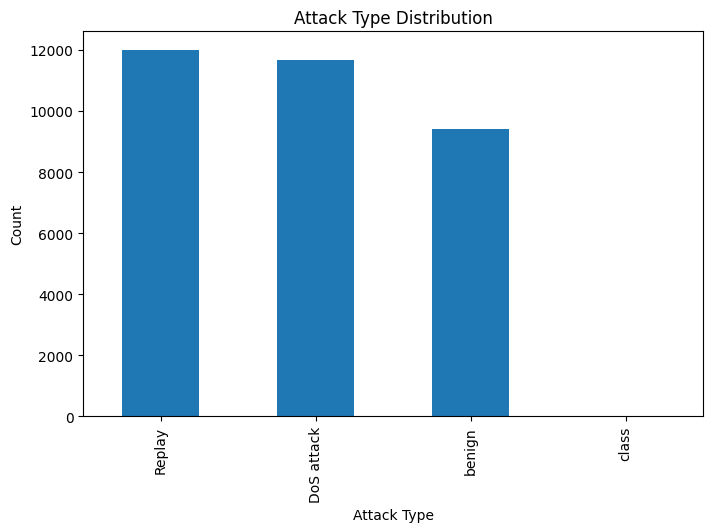

In [ ]:
plt.figure(figsize=(8,5))
df_uav['class'].value_counts().plot(kind='bar')
plt.title("Attack Type Distribution")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.show()

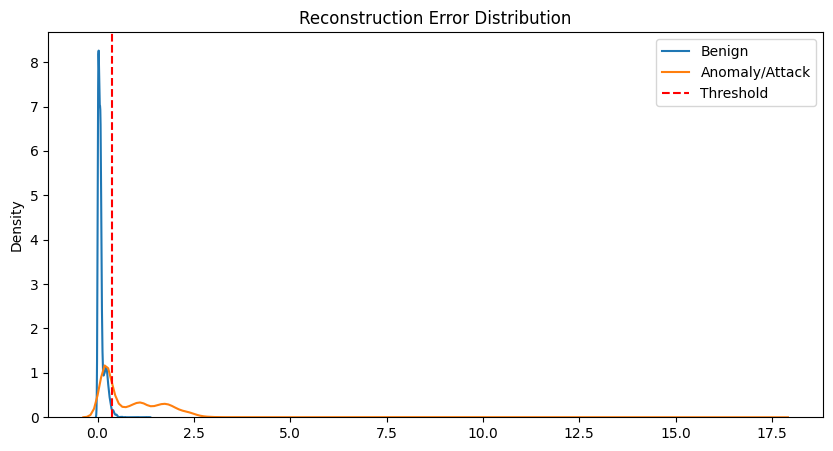

In [ ]:
plt.figure(figsize=(10,5))
sns.kdeplot(mse[benign_mask], label='Benign')
sns.kdeplot(mse[~benign_mask], label='Anomaly/Attack')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution")
plt.legend()
plt.show()

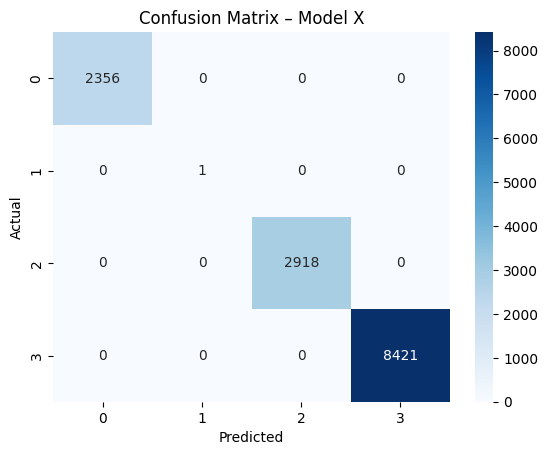

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Model X")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

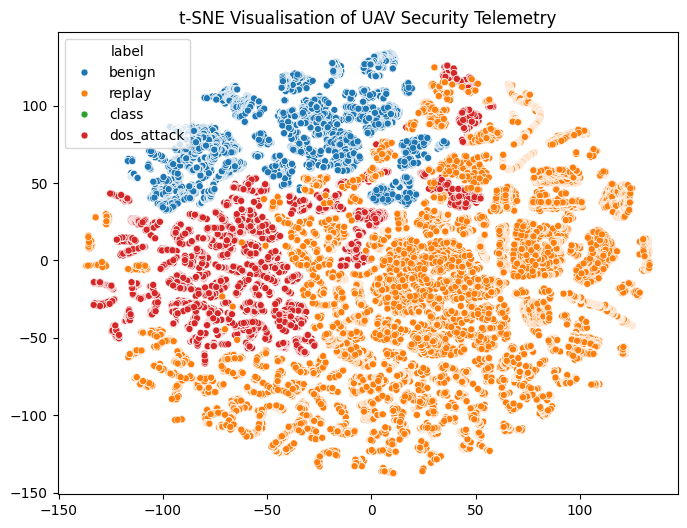

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, perplexity=30).fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, s=25)
plt.title("t-SNE Visualisation of UAV Security Telemetry")
plt.show()

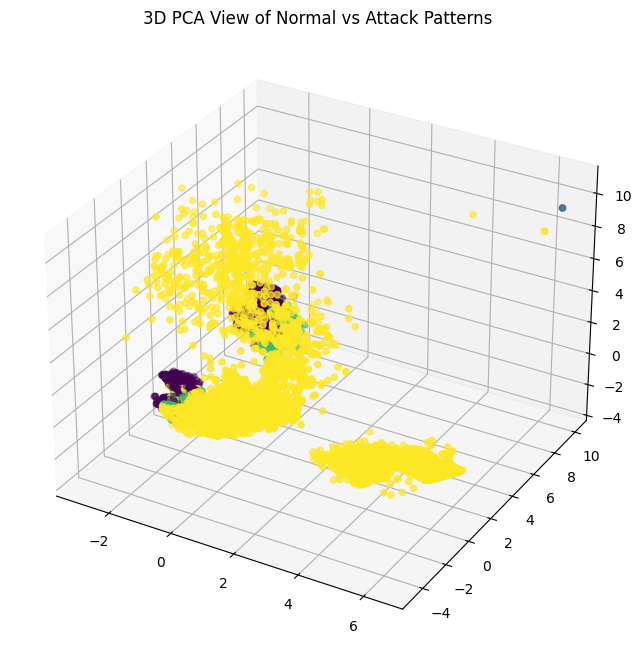

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=y.astype('category').cat.codes)
plt.title("3D PCA View of Normal vs Attack Patterns")
plt.show()

1712/1712 ━━━━━━━━━━━━━━━━━━━━ 2s 951us/step


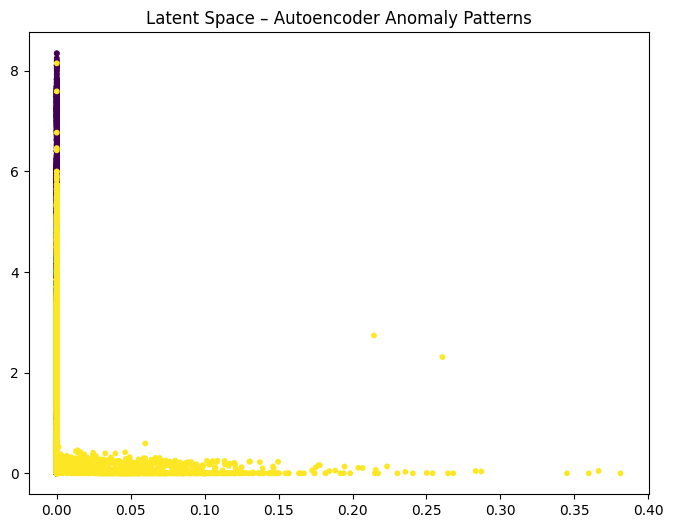

In [ ]:
encoder = models.Model(inputs, h)  # same encoder used in your AE
latent = encoder.predict(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(latent[:,0], latent[:,1], c=y.astype('category').cat.codes, s=10)
plt.title("Latent Space – Autoencoder Anomaly Patterns")
plt.show()